# Homework

1. Compare the quality of your model when using different:
 - batch sizes,
 - learning rates,
 - activation functions.

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization.



In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import time

Loading data

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 45.0MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 3.01MB/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.3MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.39MB/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Spliting training data in training and validation

In [3]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Making data set iterable

In [5]:
batch_size = 128
# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [6]:
#create dataloader for test data
# The dataloader makes our dataset iterable
batch_size_test = 128
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

Functions to train and evaluate

In [7]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [8]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

Training and evaluating base non linear classifier

In [9]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [10]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [11]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.7931470278104147, accuracy: 77.55833333333332
Epoch 0: val. loss: 0.7883197620828101, val. accuracy: 77.41666666666667
Epoch 1: training loss: 0.3977799408038457, accuracy: 88.76666666666667
Epoch 1: val. loss: 0.3910757883432064, val. accuracy: 88.59166666666667
Epoch 2: training loss: 0.30534360659122467, accuracy: 91.06875
Epoch 2: val. loss: 0.3002758609487655, val. accuracy: 91.0
Epoch 3: training loss: 0.2494559362133344, accuracy: 92.77499999999999
Epoch 3: val. loss: 0.2470898376183307, val. accuracy: 92.41666666666667
Epoch 4: training loss: 0.21087664417425792, accuracy: 93.87291666666667
Epoch 4: val. loss: 0.2131510128841755, val. accuracy: 93.35833333333333
CPU times: user 1min 13s, sys: 178 ms, total: 1min 14s
Wall time: 1min 15s


Evaluate the model on test data

In [12]:
acc_test, loss_test = evaluate(test_dataloader, nonlinear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.2084, test accuracy: 93.44%


## Trying different batch sizes

In [ ]:
%%time

batch_size = {32, 64, 128, 256, 512} #
epochs = 5
df = pd.DataFrame({'N': range(1,epochs +1)})

for k in batch_size:

  train_dataloader = torch.utils.data.DataLoader(training_data, batch_size= k)
  val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size= k)

  nonlinear_model = NonlinearClassifier()
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

  train_acc_all = []
  val_acc_all = []

  for j in range(epochs):

    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

  df['train_acc_'+ str(k)] = train_acc_all
  df['val_acc_'+ str(k)] = val_acc_all


Epoch 0: training loss: 0.26678604547555246, accuracy: 92.34583333333333
Epoch 0: val. loss: 0.26045400082071624, val. accuracy: 92.11666666666667
Epoch 1: training loss: 0.16921655371971428, accuracy: 95.09791666666668
Epoch 1: val. loss: 0.1697160162826379, val. accuracy: 95.025
Epoch 2: training loss: 0.13189899663285662, accuracy: 96.1625
Epoch 2: val. loss: 0.1424642964179317, val. accuracy: 95.86666666666666
Epoch 3: training loss: 0.11775759555771947, accuracy: 96.50625000000001
Epoch 3: val. loss: 0.13292712304368615, val. accuracy: 96.04166666666667
Epoch 4: training loss: 0.10022560791686798, accuracy: 97.11874999999999
Epoch 4: val. loss: 0.11975842642659942, val. accuracy: 96.55833333333334
Epoch 0: training loss: 1.9618840363431485, accuracy: 34.014583333333334
Epoch 0: val. loss: 1.9599870062888938, val. accuracy: 34.425
Epoch 1: training loss: 0.8030296310465387, accuracy: 74.14791666666667
Epoch 1: val. loss: 0.7999332407687573, val. accuracy: 73.78333333333333
Epoch 2:

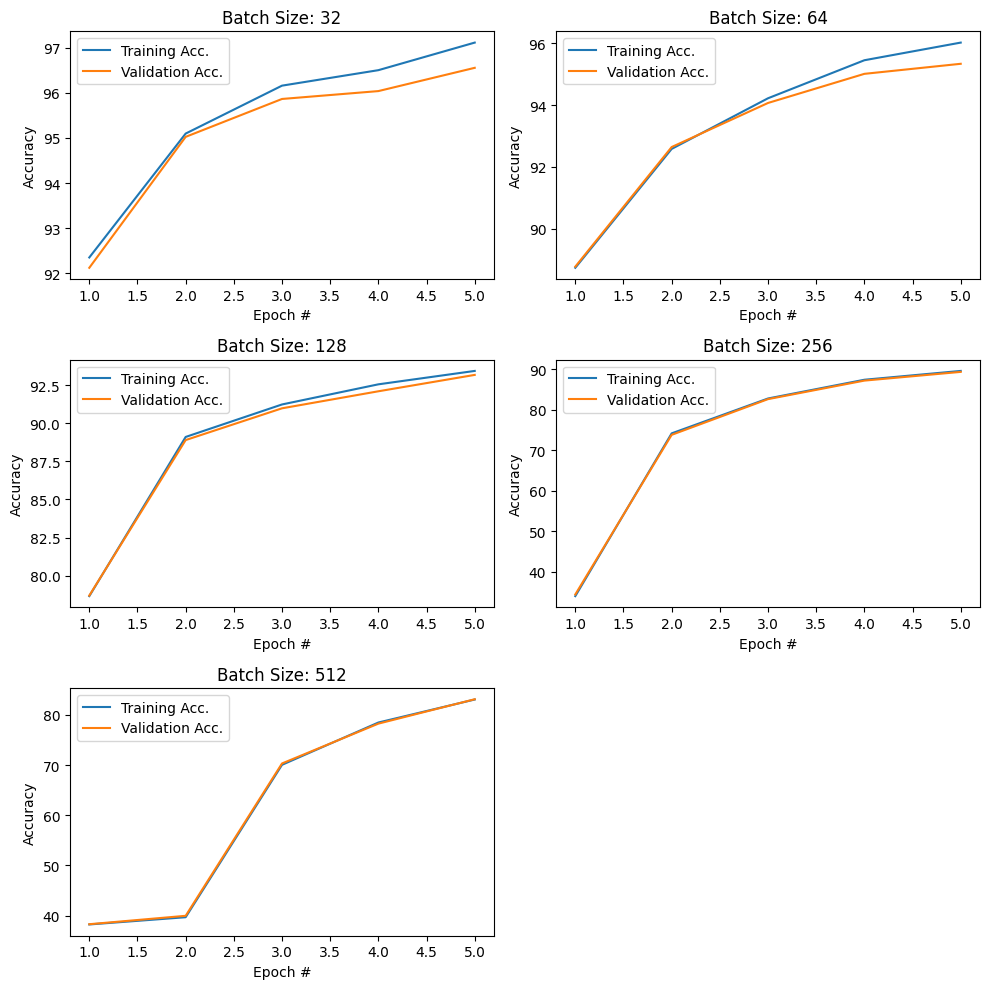

In [ ]:
pltsize = 1
fig, axes = plt.subplots(3, 2, figsize=(10 * pltsize, 10 * pltsize))

batch_sizes = [32, 64, 128, 256, 512]
axes_flat = axes.flatten()  # Flatten axes for easier iteration

for i, batch_size in enumerate(batch_sizes):
    ax = axes_flat[i]  # Get the current axes
    ax.plot(df['N'], df['train_acc_' + str(batch_size)], label='Training Acc.')
    ax.plot(df['N'], df['val_acc_' + str(batch_size)], label='Validation Acc.')
    ax.set_xlabel('Epoch #')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.set_title(f'Batch Size: {batch_size}')  # Add title for clarity

# Hide any unused subplots
if len(batch_sizes) < len(axes_flat):
    for j in range(len(batch_sizes), len(axes_flat)):
        axes_flat[j].set_visible(False)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

## Trying different learning rates

In [14]:
%%time

learning_rate = {0.005, 0.005, 0.05, 0.5, 5} #
epochs = 5
df = pd.DataFrame({'N': range(1,epochs +1)})

for k in learning_rate:

  train_dataloader = torch.utils.data.DataLoader(training_data, batch_size= 128)
  val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size= 128)

  nonlinear_model = NonlinearClassifier()
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr = k)

  train_acc_all = []
  val_acc_all = []

  for j in range(epochs):

    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

  df['train_acc_'+ str(k)] = train_acc_all
  df['val_acc_'+ str(k)] = val_acc_all

Epoch 0: training loss: 0.7233988593419393, accuracy: 79.30208333333333
Epoch 0: val. loss: 0.7173513979353803, val. accuracy: 78.95833333333333
Epoch 1: training loss: 0.3871851821343104, accuracy: 89.12916666666668
Epoch 1: val. loss: 0.3793193298451444, val. accuracy: 89.075
Epoch 2: training loss: 0.3084167700211207, accuracy: 91.14375
Epoch 2: val. loss: 0.3035179026266362, val. accuracy: 90.83333333333333
Epoch 3: training loss: 0.25353276149431864, accuracy: 92.68541666666667
Epoch 3: val. loss: 0.25203086895511506, val. accuracy: 92.61666666666667
Epoch 4: training loss: 0.21661038432518642, accuracy: 93.85625
Epoch 4: val. loss: 0.2169808437849613, val. accuracy: 93.61666666666667
Epoch 0: training loss: 0.22289122788111368, accuracy: 93.39375
Epoch 0: val. loss: 0.22583590503385725, val. accuracy: 93.4
Epoch 1: training loss: 0.15697747006018956, accuracy: 95.24375
Epoch 1: val. loss: 0.1612243058675147, val. accuracy: 95.125
Epoch 2: training loss: 0.14347283661862215, accur

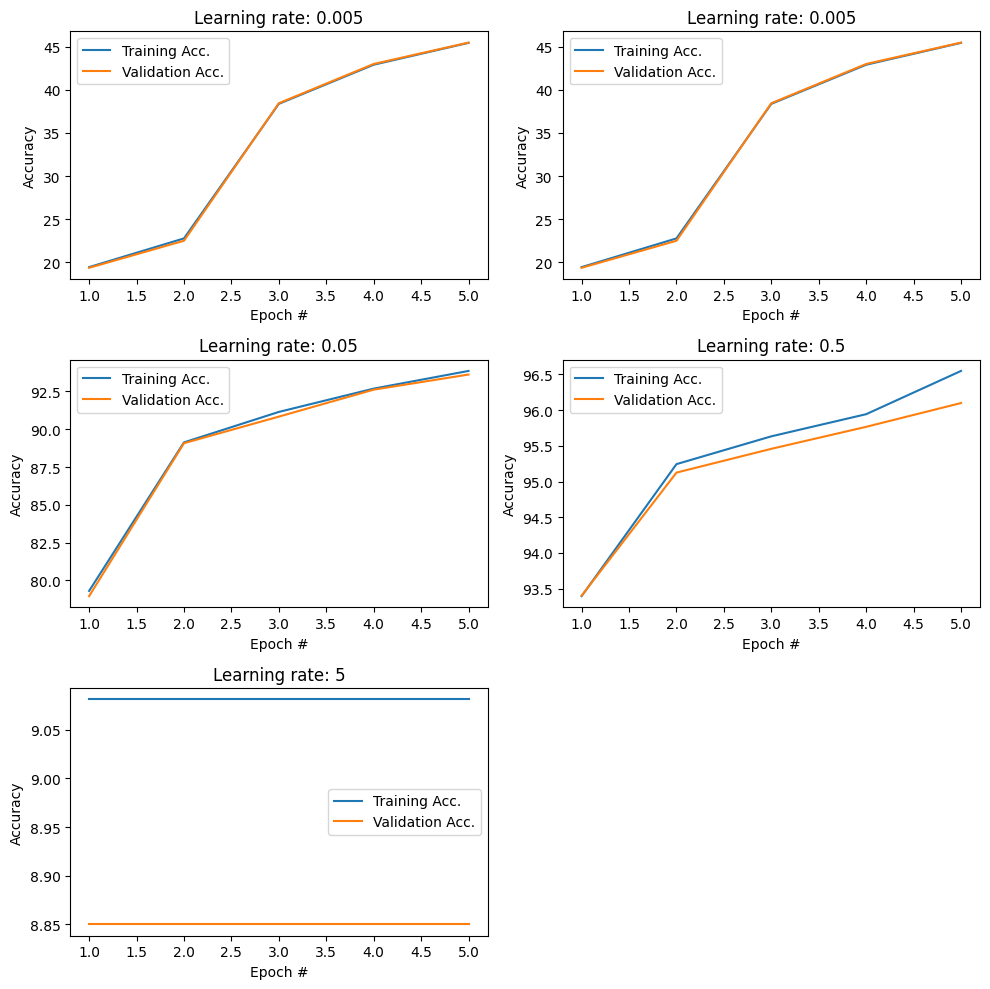

In [16]:
pltsize = 1
fig, axes = plt.subplots(3, 2, figsize=(10 * pltsize, 10 * pltsize))

learning_rates = [0.005, 0.005, 0.05, 0.5, 5]
axes_flat = axes.flatten()  # Flatten axes for easier iteration

for i, learning_rate in enumerate(learning_rates):
    ax = axes_flat[i]  # Get the current axes
    ax.plot(df['N'], df['train_acc_' + str(learning_rate)], label='Training Acc.')
    ax.plot(df['N'], df['val_acc_' + str(learning_rate)], label='Validation Acc.')
    ax.set_xlabel('Epoch #')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.set_title(f'Learning rate: {learning_rate}')  # Add title for clarity

# Hide any unused subplots
if len(learning_rates) < len(axes_flat):
    for j in range(len(learning_rates), len(axes_flat)):
        axes_flat[j].set_visible(False)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

## Trying different activation functions

In [20]:
class NonlinearClassifier(nn.Module):
    def __init__(self, activation_fn=nn.ReLU):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            activation_fn(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            activation_fn(),
            nn.Linear(50, 50),
            activation_fn(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)
        return x


Epoch 0: training loss: 0.7444093774159749, accuracy: 78.87708333333333
Epoch 0: val. loss: 0.7372931660489833, val. accuracy: 79.10000000000001
Epoch 1: training loss: 0.39914694412549334, accuracy: 88.39375000000001
Epoch 1: val. loss: 0.3940834697890789, val. accuracy: 88.30833333333334
Epoch 2: training loss: 0.29854870422681173, accuracy: 91.38958333333333
Epoch 2: val. loss: 0.29383086714338746, val. accuracy: 91.21666666666667
Epoch 3: training loss: 0.23956611706813177, accuracy: 93.08333333333333
Epoch 3: val. loss: 0.23740963558567332, val. accuracy: 92.79166666666666
Epoch 4: training loss: 0.2005908674399058, accuracy: 94.26041666666667
Epoch 4: val. loss: 0.20180846544656347, val. accuracy: 93.88333333333333


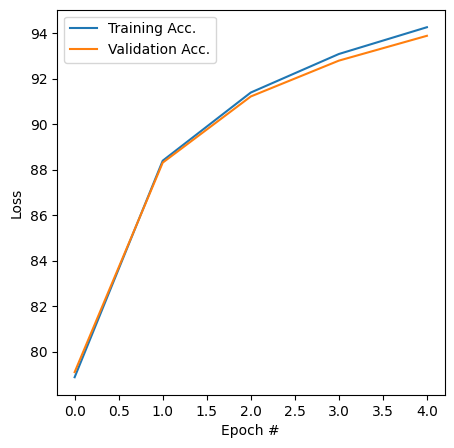

In [21]:
model = NonlinearClassifier(activation_fn=nn.Tanh)

nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

pltsize = 0.5
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Epoch 0: training loss: 0.8971223454475403, accuracy: 77.06041666666667
Epoch 0: val. loss: 0.89719128735522, val. accuracy: 76.69166666666666
Epoch 1: training loss: 0.41095349097251893, accuracy: 88.23333333333333
Epoch 1: val. loss: 0.40536500830599603, val. accuracy: 88.175
Epoch 2: training loss: 0.30667134896914167, accuracy: 91.20416666666667
Epoch 2: val. loss: 0.29918278198927006, val. accuracy: 91.15833333333333
Epoch 3: training loss: 0.2449894996682803, accuracy: 92.925
Epoch 3: val. loss: 0.24053903391703646, val. accuracy: 92.925
Epoch 4: training loss: 0.2041461155017217, accuracy: 94.04583333333333
Epoch 4: val. loss: 0.20296392312392275, val. accuracy: 93.99166666666666


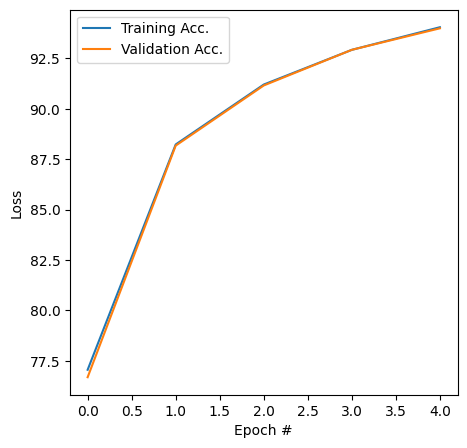

In [28]:
model = NonlinearClassifier(activation_fn=nn.Mish)

nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

pltsize = 0.5
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Epoch 0: training loss: 1.0491711757977804, accuracy: 71.62916666666666
Epoch 0: val. loss: 1.042503372785893, val. accuracy: 71.28333333333333
Epoch 1: training loss: 0.41066823196411134, accuracy: 88.3625
Epoch 1: val. loss: 0.40350588902514034, val. accuracy: 88.61666666666666
Epoch 2: training loss: 0.30646562616030376, accuracy: 91.19583333333333
Epoch 2: val. loss: 0.3003300369736996, val. accuracy: 91.08333333333334
Epoch 3: training loss: 0.2557579607963562, accuracy: 92.53125
Epoch 3: val. loss: 0.25211161818910155, val. accuracy: 92.375
Epoch 4: training loss: 0.2181424600283305, accuracy: 93.55833333333334
Epoch 4: val. loss: 0.21782506510932395, val. accuracy: 93.51666666666667


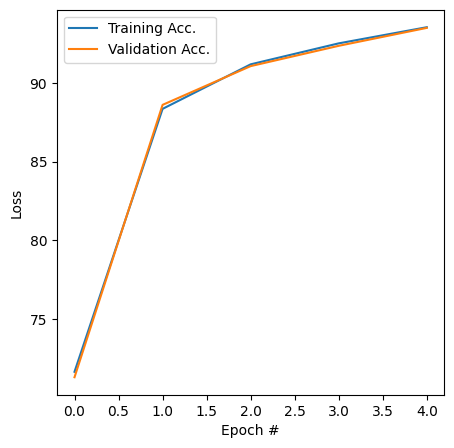

In [27]:
model = NonlinearClassifier(activation_fn=nn.ELU)

nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

pltsize = 0.5
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()